# 1. Import Dependencies

In [2]:
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from prophet import Prophet
from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdate

import pandas as pd
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

from importlib import reload
import neural_network_classes, neural_network_functions
reload(neural_network_classes), reload(neural_network_functions)
from neural_network_classes import LSTM, DARNN, HARHN
from neural_network_functions import nn_train, nn_eval, nn_forecast

print("All libraries loaded")

All libraries loaded


# 2. Download Data

In [2]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [3]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [4]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-11 00:00:00 999 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [5]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [6]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [7]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [8]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [9]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [10]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
          date  gas import volume
587 2021-12-15             252626
588 2022-01-15             296179
589 2022-02-15             259389
590 2022-03-15             260642
591 2022-04-15             246576


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [11]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
          date  gas import price
395 2021-12-15              4.74
396 2022-01-15              6.87
397 2022-02-15              5.62
398 2022-03-15              4.67
399 2022-04-15              5.46


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [12]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [13]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [14]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [15]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [16]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [17]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [18]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
          date  kerosene price
382 2022-02-15           2.682
383 2022-03-15           3.495
384 2022-04-15           3.914
385 2022-05-15           3.902
386 2022-06-15           4.120


## 2o. Propane Price (feature 15)

In [19]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
          date  propane price
356 2022-02-15          1.283
357 2022-03-15          1.448
358 2022-04-15          1.302
359 2022-05-15          1.223
360 2022-06-15          1.219


# 3. Combine Feature and Target Data

In [20]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [21]:
# reindex and concatenate features
kw = dict(method="time")
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date')
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461
2022-07-04,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,27.0,5.405


# 4. Data Preprocessing

In [22]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
n_timeseries = data.shape[1] - 1 # input size
batch_size = 16
max_epochs = 250
target_name = 'gas price' # target variable name
feature_names = features_targets.columns[0:-1].tolist()

timesteps = 4 # 10, lookback window
lstm_n_hidden = 64
lstm_n_layers = 2
darnn_n_enc_units = 64
darnn_n_dec_units = 64 # 64
harhn_n_enc_units = 64
harhn_n_dec_units = 64

## 4a. Incorporate Rolling Lookback Window

In [23]:
# Preallocate feature and target arrays
X_ = np.zeros((len(data), timesteps, data.shape[1]-1))
y_ = np.zeros((len(data), timesteps, 1))

In [24]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X_[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [25]:
for j in range(timesteps):
    y_[:, j, 0] = data[target_name].shift(timesteps - j - 1).fillna(method="bfill")

In [26]:
prediction_horizon = 1
target_ = data[target_name].shift(-prediction_horizon).fillna(method="ffill").values

## 4b. Build Training, Validation, and Testing Datasets

In [27]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

587 126 126


In [28]:
X = X_[timesteps:]
y = y_[timesteps:]
target = target_[timesteps:]

In [29]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [30]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        return (x*self.range) + self.min

In [31]:
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [32]:
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

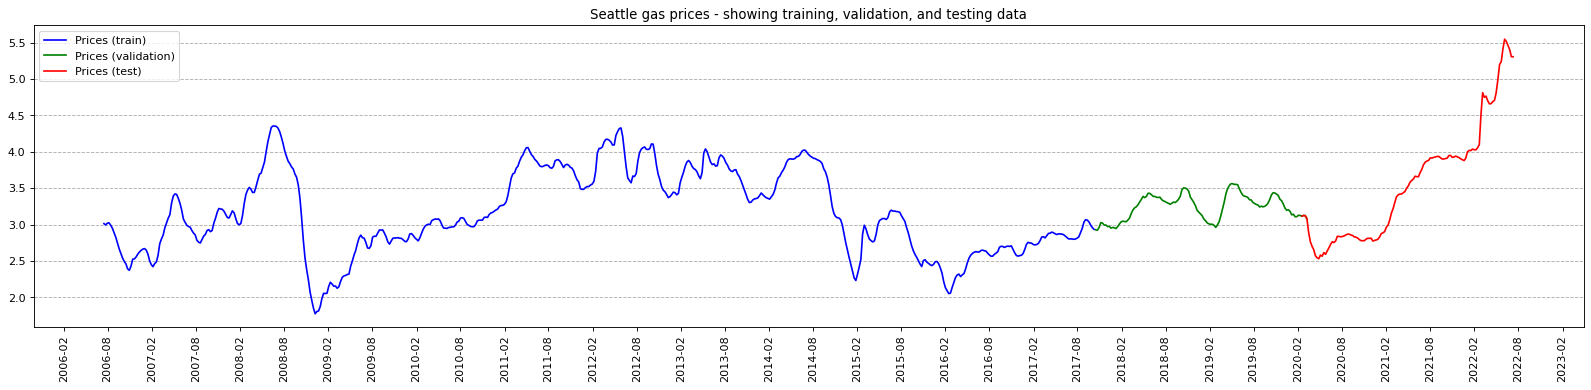

In [33]:
## Prepare data for plotting
data_date = features_targets.index.tolist()[timesteps:]
num_data_points = len(y)

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[:train_length] = target_scaler.inverse_transform(target_train)
to_plot_data_y_val[train_length:train_length+val_length] = target_scaler.inverse_transform(target_val)
to_plot_data_y_test[-val_length:] = target_scaler.inverse_transform(target_test)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## Plotting
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='green')
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color='red')

# Format the x axis
locator = mdate.MonthLocator(interval=6)
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
# plt.xlim([data_date[0], data_date[-1]])

plt.title("Seattle gas prices - showing training, validation, and testing data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 4d. Build Torch Data Loaders

In [34]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [35]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 5. Modeling

## 5a. Facebook Prophet

### Training

In [36]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

n = NeuralProphet()
df_train, df_test = n.split_df(df=df, freq="W", valid_p=0.15)

params = {
    "changepoint_prior_scale": 0.25,
    "changepoint_range": 0.90,
    "interval_width": 0.95
}

# Train
m = Prophet(**params)
metrics =  m.fit(df_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
10:43:58 - cmdstanpy - INFO - Chain [1] start processing
10:43:59 - cmdstanpy - INFO - Chain [1] done processing


### Evaluation

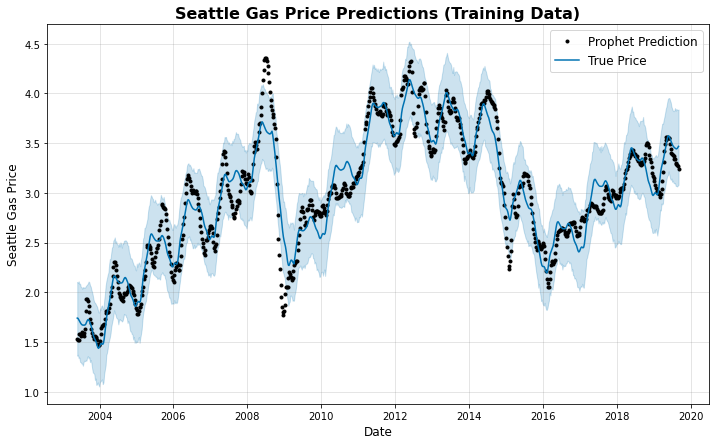

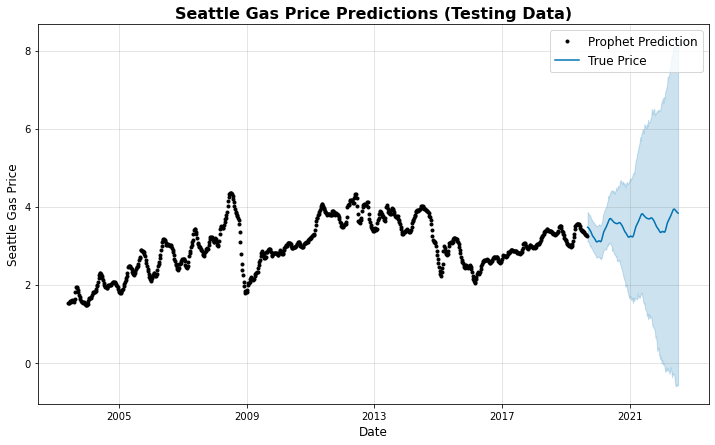

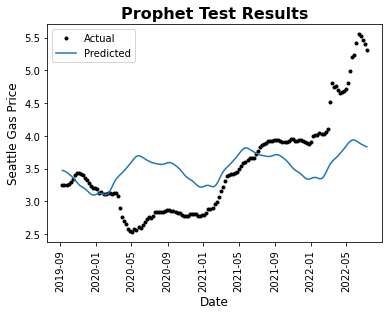

[0.42294241364464746, 0.5174360787890214, 0.22025914540502822, 0.5181583693643318]


In [37]:
train_pred = m.predict(df_train)

fig1 = m.plot(train_pred)
ax = fig1.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Training Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Prophet Prediction', 'True Price'], fontsize=12)

eval_pred = m.predict(df_test)

fig2 = m.plot(eval_pred)
ax = fig2.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Testing Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Prophet Prediction', 'True Price'], fontsize=12)

fig3 = plt.figure()
y_true= df_test['y'].values
y_pred = eval_pred['yhat'].values
plt.plot(df_test['ds'], y_true, label='Actual', marker='.', linestyle='', color='k')
plt.plot(df_test['ds'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Prophet Test Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.show()

# metrics
prophet_mse = mean_squared_error(y_true, y_pred)
prophet_mae = mean_absolute_error(y_true, y_pred)
prophet_r2 = r2_score(y_true, y_pred)
prophet_pcc = PCC(y_true, y_pred)[0]

print([prophet_mse, prophet_mae, prophet_r2, prophet_pcc])

### Forecasting

10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing


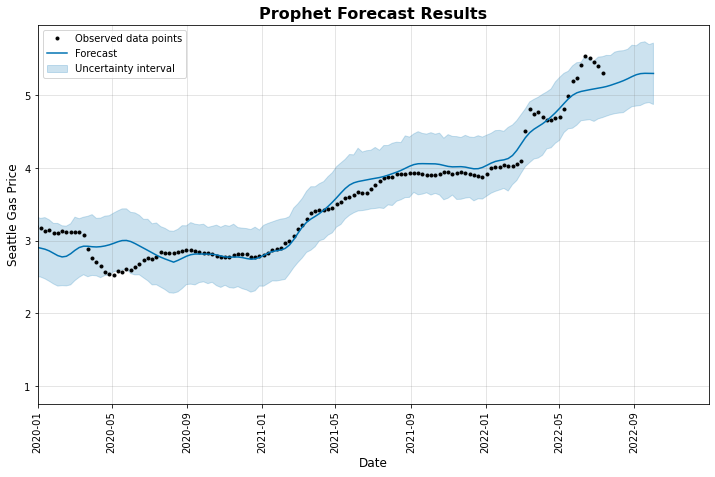

In [38]:
# Re-fit to all data
m = Prophet(**params)
metrics =  m.fit(df)

# Forecast
future = m.make_future_dataframe(periods=12, freq='W', include_history=True)
forecast = m.predict(future)

fig4 = m.plot(forecast)
ax = fig4.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-01-01', '2022-12-31'])) 
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Prophet Forecast Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

## 5b. Facebook Neural Prophet

### Training

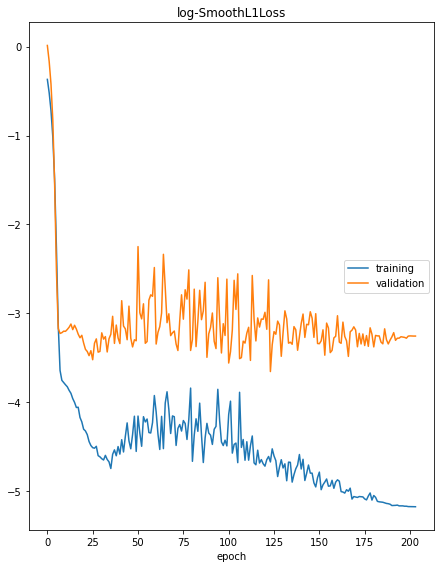

log-SmoothL1Loss
	training         	 (min:   -5.177, max:   -0.368, cur:   -5.177)
	validation       	 (min:   -3.656, max:    0.014, cur:   -3.256)


In [39]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    "changepoints_range": 0.90, 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

### Evaluation

In [40]:
test_pred = model.predict(df_test)
test_metrics = model.test(df_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.039  0.583  0.704


INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.882% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.882% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


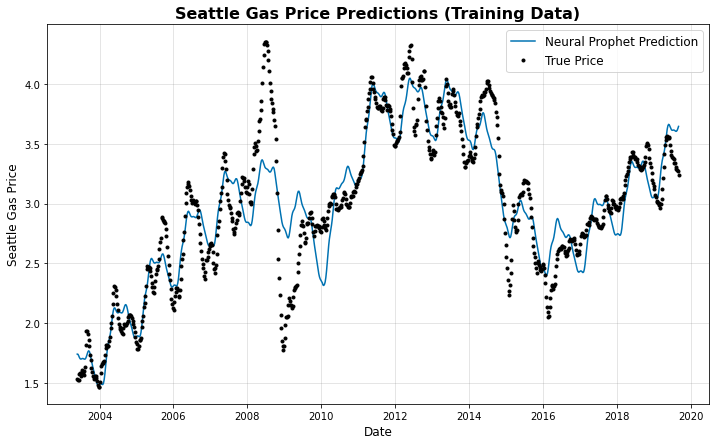

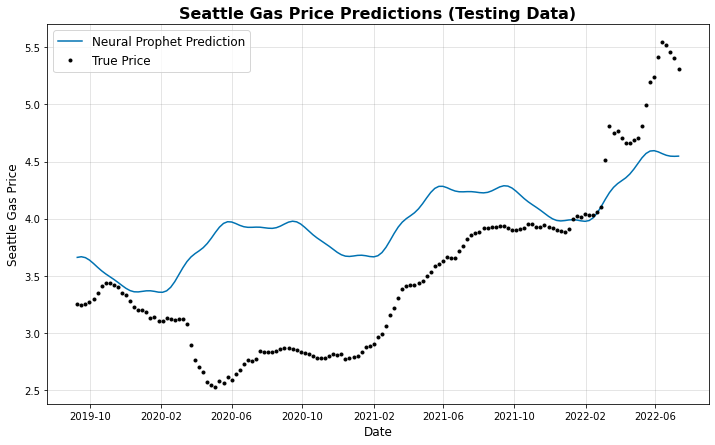

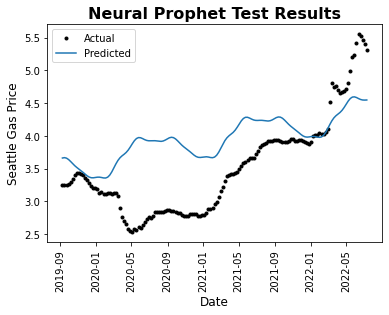

[0.49564829394789894, 0.5827870357052592, 0.08621785890173395, 0.7200635810784619]


In [41]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
# model.plot(model.predict(df), ax=ax1)
# ax1.set_xlabel('Date', fontsize=14)
# ax1.set_ylabel('Seattle Gas Price', fontsize=14)
# ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
# ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
# ax2.set_xlabel('Date', fontsize=14)
# ax2.set_ylabel('Seattle Gas Price', fontsize=14)
# ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

fig1 = model.plot(model.predict(df_train))
ax = fig1.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Training Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Neural Prophet Prediction', 'True Price'], fontsize=12)

eval_pred = model.predict(df_test)

fig2 = model.plot(eval_pred)
ax = fig2.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Testing Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Neural Prophet Prediction', 'True Price'], fontsize=12)

fig3 = plt.figure()
y_true = test_pred['y'].values
y_pred = test_pred['yhat1'].values
plt.plot(df_test['ds'], y_true, label='Actual', marker='.', linestyle='', color='k')
plt.plot(df_test['ds'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Neural Prophet Test Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.show()

# metrics
nprophet_mse = mean_squared_error(y_true, y_pred)
nprophet_mae = mean_absolute_error(y_true, y_pred)
nprophet_r2 = r2_score(y_true, y_pred)
nprophet_pcc = PCC(y_true, y_pred)[0]

print([nprophet_mse, nprophet_mae, nprophet_r2, nprophet_pcc])

### Forecasting

In [42]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 194


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.86E-01, min: 1.58E+00


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.21E-01, min: 2.96E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.91E-01
Epoch[194/194]: 100%|██████████| 194/194 [00:29<00:00,  6.59it/s, SmoothL1Loss=0.00778, MAE=0.235, RMSE=0.314, RegLoss=0]


In [43]:
# fig = model.plot(model2.predict(df))
# fig, ax = plt.subplots(figsize=(15, 7))
# model.plot(model.predict(df), ax=ax)
# # ax.set_xlabel('Date', fontsize=14)
# # ax.set_ylabel('Seattle Gas Price', fontsize=14)
# # ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
# ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [44]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - c:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - c:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

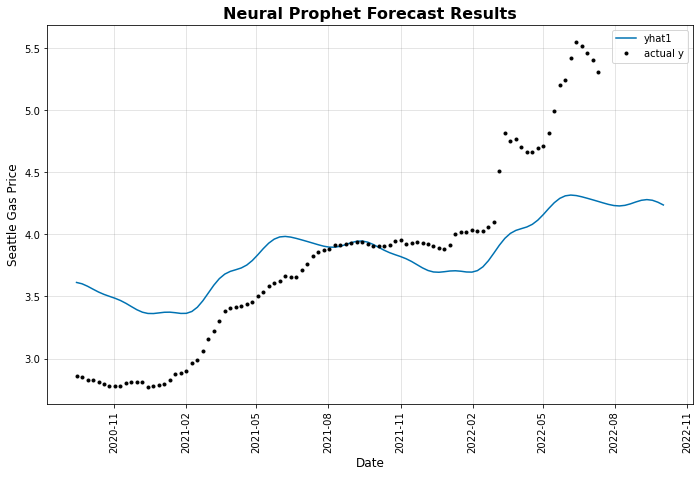

In [45]:
fig = model2.plot(forecast)
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-01-01', '2022-12-31'])) 
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Neural Prophet Forecast Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

## 5c. Neural Network (LSTM)

### Training

In [46]:
lstm = LSTM(num_classes=1, input_size=n_timeseries+1, hidden_size=lstm_n_hidden, num_layers=lstm_n_layers, # hidden=64, layers=2
             seq_length=timesteps, device=device, dropout=0.2)
model_name = 'lstm'
lstm_opt = optim.AdamW(lstm.parameters(), lr=0.01)
lstm_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=lstm_opt, patience=15)

Validation loss decreased (inf --> 0.064073).  Saving model ...
Iter:  0 train:  0.8060220342388845 val:  0.11770133517172252 LR:  0.01
mse:  0.027100042 mae:  0.13547431


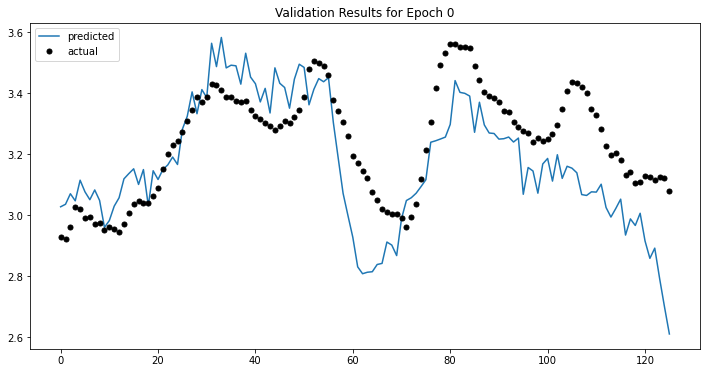

EarlyStopping counter: 1 out of 50
Iter:  1 train:  0.2784954321289375 val:  0.19018088641007047 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  2 train:  0.2216407449661303 val:  0.2459524154666344 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  3 train:  0.21263159106320859 val:  0.2302034710610904 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  4 train:  0.2005512061278722 val:  0.19490065777613783 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  5 train:  0.20163678962585088 val:  0.22756357573131192 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  6 train:  0.17202747862698226 val:  0.1846267546933892 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  7 train:  0.17476075932401985 val:  0.2273948771465336 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  8 train:  0.1639980178378058 val:  0.15875349888055515 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  9 train:  0.15061506631901853 val:  0.16377750827264187 LR:  0.01
Validation loss decreased (0.064073 

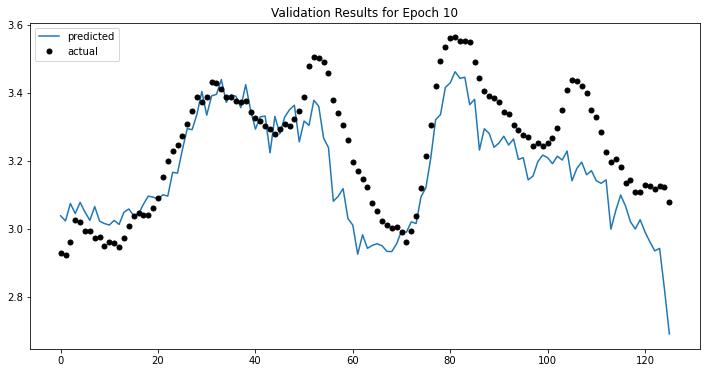

EarlyStopping counter: 1 out of 50
Iter:  11 train:  0.15973379467660995 val:  0.1412467867705006 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  12 train:  0.1458822591743719 val:  0.14101096082214978 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  13 train:  0.1335006001527594 val:  0.11573703959028808 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  14 train:  0.1619435126490111 val:  0.13963892726692526 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  15 train:  0.1434448370244253 val:  0.222085756386313 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  16 train:  0.17859390490089128 val:  0.09540586984024096 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  17 train:  0.14410258001980392 val:  0.10589737910931823 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  18 train:  0.15088702216884184 val:  0.1652770194503909 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  19 train:  0.129480947906116 val:  0.13460681518539158 LR:  0.01
EarlyStopping counter: 10 out

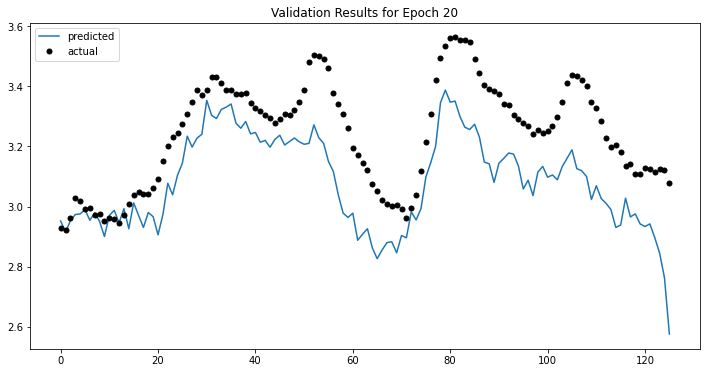

EarlyStopping counter: 11 out of 50
Iter:  21 train:  0.1361657351282789 val:  0.10740604494882482 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  22 train:  0.11982522194872901 val:  0.11781937410979217 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  23 train:  0.12536248336047304 val:  0.12292027952080878 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  24 train:  0.13894507654955365 val:  0.11587332343037608 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  25 train:  0.1498941656584105 val:  0.11002434045389582 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  26 train:  0.11698561964501643 val:  0.10687763303868826 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  27 train:  0.10398898046635784 val:  0.10805931112933406 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  28 train:  0.09799931977951039 val:  0.11170121175853165 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  29 train:  0.09567219383735406 val:  0.11354688653195032 LR:  0.001
EarlySto

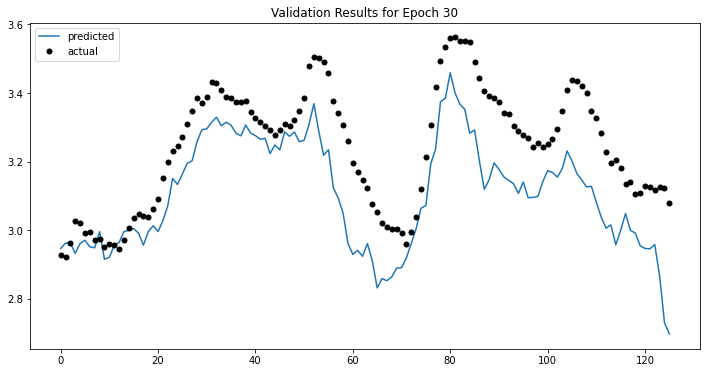

EarlyStopping counter: 21 out of 50
Iter:  31 train:  0.09368828502404693 val:  0.1076410644804632 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  32 train:  0.09272457165906178 val:  0.10968071087257732 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  33 train:  0.09113195774028574 val:  0.10644150462174694 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  34 train:  0.09016732510267988 val:  0.11181380063913995 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  35 train:  0.08952056276255986 val:  0.11548267793704013 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  36 train:  0.09231249137677404 val:  0.11692429232505905 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  37 train:  0.09316993885696603 val:  0.11524574729448891 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  38 train:  0.08965152529048716 val:  0.11250501605085265 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  39 train:  0.08687655316096983 val:  0.0928294163517622 LR:  0.001
Ear

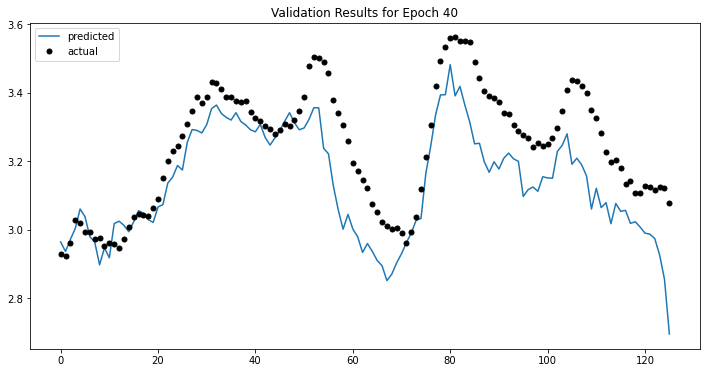

EarlyStopping counter: 31 out of 50
Iter:  41 train:  0.09055171987987079 val:  0.09137011909446348 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  42 train:  0.09007843542989576 val:  0.09563646764019064 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  43 train:  0.08678527344831172 val:  0.10515638121209572 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  44 train:  0.08340078058456317 val:  0.10687594894365401 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  45 train:  0.08460730955008264 val:  0.10312436829378553 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  46 train:  0.08714858140519316 val:  0.10444732304730135 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  47 train:  0.0820619992123522 val:  0.11041290031595544 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  48 train:  0.08321733750274059 val:  0.10824640167362731 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  49 train:  0.08301294470873014 val:  0.10750475060213457 LR:  0

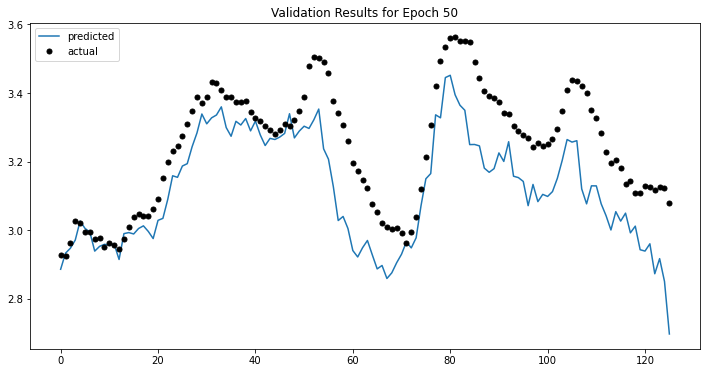

EarlyStopping counter: 41 out of 50
Iter:  51 train:  0.08102978553510382 val:  0.10430638281733637 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  52 train:  0.0845692121035201 val:  0.1066475960171671 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  53 train:  0.08586635354026534 val:  0.1012393868472964 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  54 train:  0.08395394226096616 val:  0.1055728655727232 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  55 train:  0.08734062126270783 val:  0.09905703212319303 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  56 train:  0.08394983110175384 val:  0.10400797120582239 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  57 train:  0.08393642299188799 val:  0.09961357677034674 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  58 train:  0.08133548893553814 val:  0.10880500630672418 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  59 train:  0.08426844695424847 val:  0.10444594309274212 LR:  1e-0

In [47]:
nn_train(model=lstm, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=lstm_opt, 
         scheduler=lstm_scheduler,
         target_scaler=target_scaler,
         device=device,
         plot=True)

### Evaluation

In [48]:
lstm.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

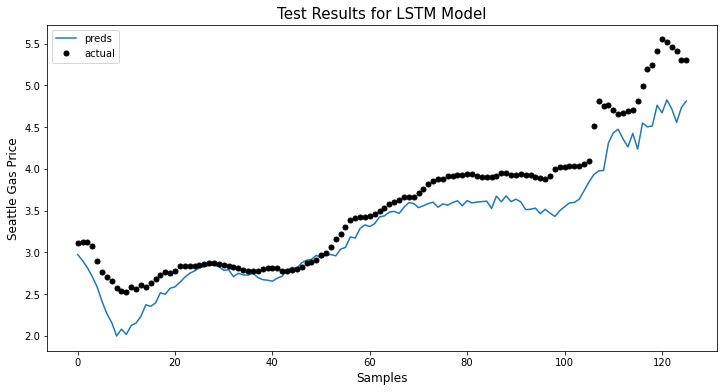

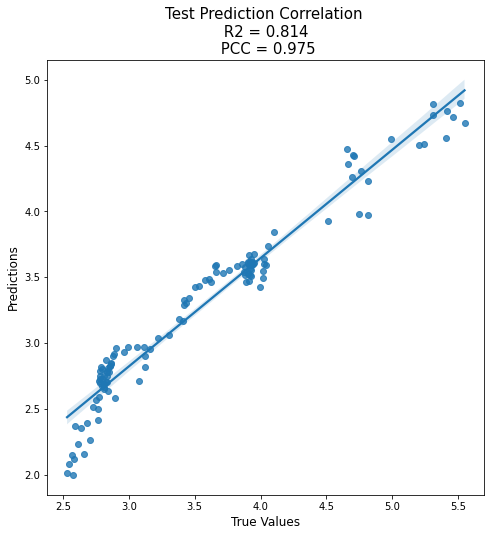

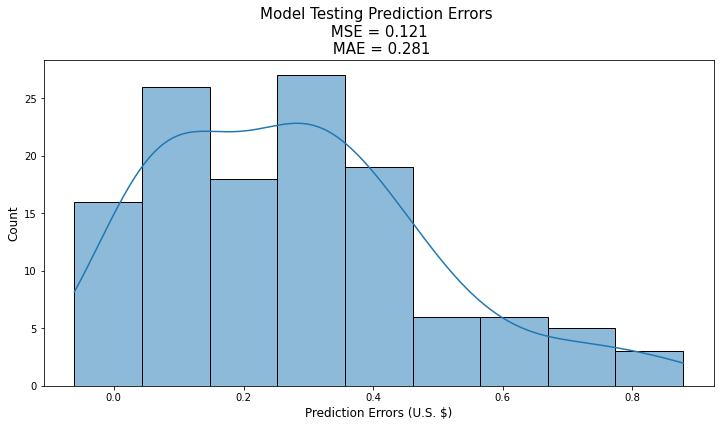

In [49]:
lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_true, _, _ = nn_eval(model=lstm, 
                                                                             model_name='lstm', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler, 
                                                                             device=device, 
                                                                             cols=feature_names
                                                                             )

### Forecasting

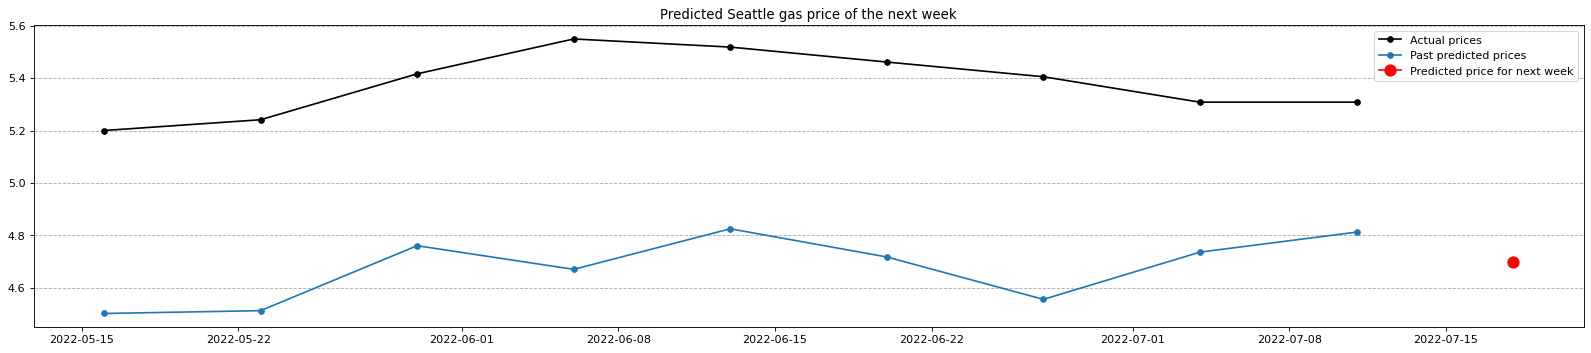

LSTM Predicted Seattle Gas Price of the next week: $4.70


In [50]:
nn_forecast(model = lstm,
            model_name = 'lstm', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = lstm_true, 
            preds = lstm_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler,
            device=device, 
            dates=data_date,
            plot_range=10
           )

## 5d. Dual-Stage Attention-Based Recurrent Neural Network (DA-RNN)

### Training

In [51]:
darnn = DARNN(N=X_train.shape[2], M=darnn_n_enc_units, P=darnn_n_dec_units, # 1) M=64, P=16
              T=X_train.shape[1], device=device).to(device) 
model_name = 'darnn'
darnn_opt = optim.AdamW(darnn.parameters(), lr=0.01)
darnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=darnn_opt, patience=15)

Validation loss decreased (inf --> 1.210778).  Saving model ...
Iter:  0 train:  0.8612095368128758 val:  0.5116540538547248 LR:  0.01
mse:  0.51210624 mae:  0.6924556


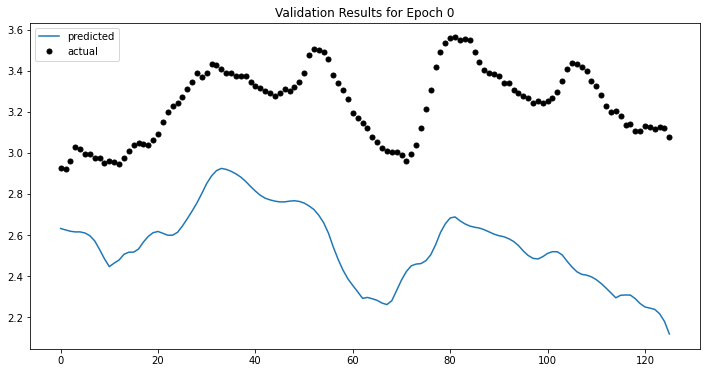

Validation loss decreased (1.210778 --> 0.664491).  Saving model ...
Iter:  1 train:  0.37897428539226374 val:  0.37904327531753546 LR:  0.01
Validation loss decreased (0.664491 --> 0.393466).  Saving model ...
Iter:  2 train:  0.2484007944249939 val:  0.29167401397808396 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  3 train:  0.21969476279271583 val:  0.3138823568215736 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  4 train:  0.24605694067579847 val:  0.3683922115626155 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  5 train:  0.2400893337690598 val:  0.30411982210751615 LR:  0.01
Validation loss decreased (0.393466 --> 0.288317).  Saving model ...
Iter:  6 train:  0.2158432310731248 val:  0.249677624814761 LR:  0.01
Validation loss decreased (0.288317 --> 0.257947).  Saving model ...
Iter:  7 train:  0.2003808862986176 val:  0.2361614597331288 LR:  0.01
Validation loss decreased (0.257947 --> 0.199639).  Saving model ...
Iter:  8 train:  0.18628212055687463 val:  0.207

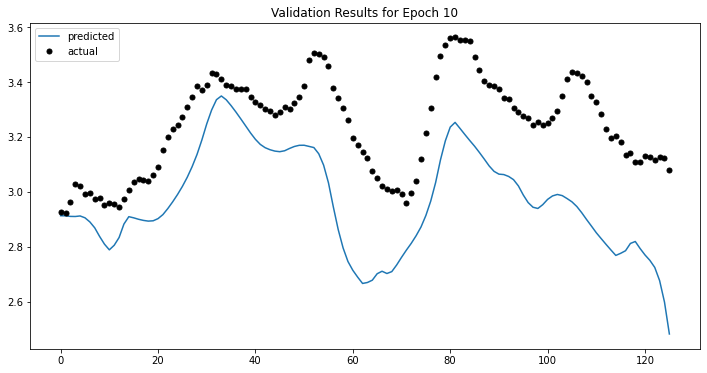

EarlyStopping counter: 3 out of 50
Iter:  11 train:  0.16082688821545746 val:  0.21598211150318386 LR:  0.01
Validation loss decreased (0.199639 --> 0.169917).  Saving model ...
Iter:  12 train:  0.1605904195101202 val:  0.19167388309722513 LR:  0.01
Validation loss decreased (0.169917 --> 0.074347).  Saving model ...
Iter:  13 train:  0.12920439809073225 val:  0.12678753180732366 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  14 train:  0.12483099121641775 val:  0.12832007971286669 LR:  0.01
Validation loss decreased (0.074347 --> 0.069007).  Saving model ...
Iter:  15 train:  0.11184461791050967 val:  0.12214933693358587 LR:  0.01
Validation loss decreased (0.069007 --> 0.062827).  Saving model ...
Iter:  16 train:  0.11115717743621928 val:  0.11655102830277281 LR:  0.01
Validation loss decreased (0.062827 --> 0.024703).  Saving model ...
Iter:  17 train:  0.07530245316949337 val:  0.07308377386546665 LR:  0.01
Validation loss decreased (0.024703 --> 0.012147).  Saving model ...

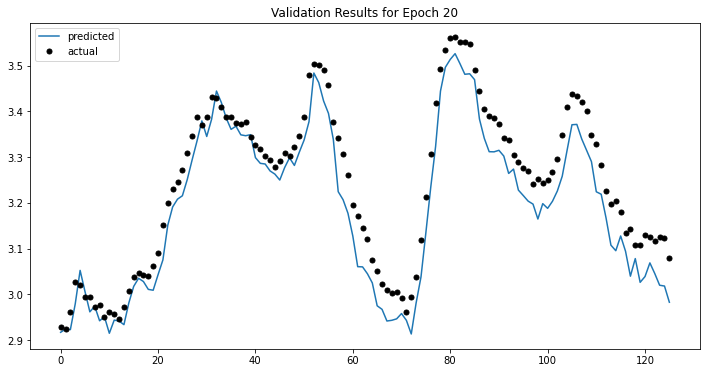

Validation loss decreased (0.008277 --> 0.007151).  Saving model ...
Iter:  21 train:  0.07337515222981943 val:  0.03932051210146883 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  22 train:  0.10681387292641835 val:  0.12536319791387124 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  23 train:  0.06965093857980592 val:  0.059886118873707 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  24 train:  0.06188720115121068 val:  0.07726233308696935 LR:  0.01
Validation loss decreased (0.007151 --> 0.005733).  Saving model ...
Iter:  25 train:  0.07441168132283167 val:  0.03520828923113113 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  26 train:  0.0650398945338669 val:  0.061325052257924256 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  27 train:  0.08160257291955138 val:  0.06106995132052251 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  28 train:  0.06736633665377208 val:  0.06761680399949917 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  29 train:  0.0623044

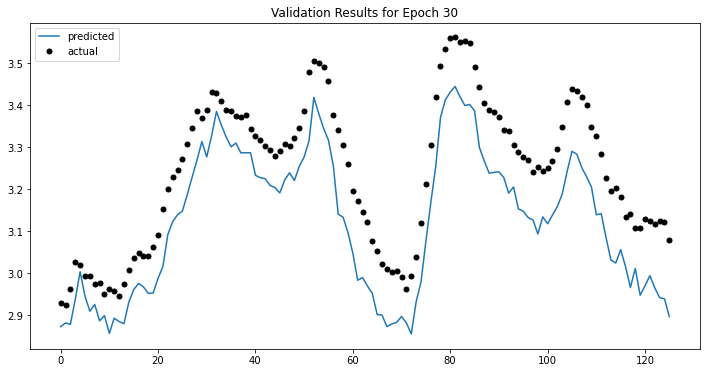

Validation loss decreased (0.005733 --> 0.003342).  Saving model ...
Iter:  31 train:  0.06826256754765932 val:  0.026880773542241786 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  32 train:  0.07947526768460993 val:  0.06124131331814164 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  33 train:  0.06501780134131832 val:  0.03842922345149293 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  34 train:  0.06996868325619132 val:  0.042870661461308766 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  35 train:  0.07367872362624334 val:  0.07174656717176331 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  36 train:  0.061794042619836745 val:  0.04335031959656243 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  37 train:  0.07698817849364047 val:  0.06438072439484512 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  38 train:  0.08730566797738636 val:  0.06655777128710749 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  39 train:  0.07589817932102765 val:  0.0851918346

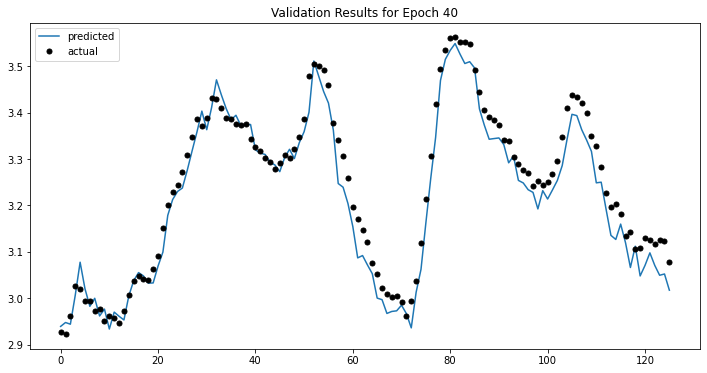

EarlyStopping counter: 10 out of 50
Iter:  41 train:  0.06265786497815234 val:  0.06678584618830744 LR:  0.01
Validation loss decreased (0.003342 --> 0.002718).  Saving model ...
Iter:  42 train:  0.0684690970411904 val:  0.024243899554263017 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  43 train:  0.06975981497264348 val:  0.08574132736282844 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  44 train:  0.07335728425495174 val:  0.05339736041704966 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  45 train:  0.07164423505656989 val:  0.05494604672152594 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  46 train:  0.07371587419058304 val:  0.06809492722170377 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  47 train:  0.06364790271848275 val:  0.036145156215866565 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  48 train:  0.07347542776406822 val:  0.04815624518928178 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  49 train:  0.06922246174083475 val:  0.06116670932

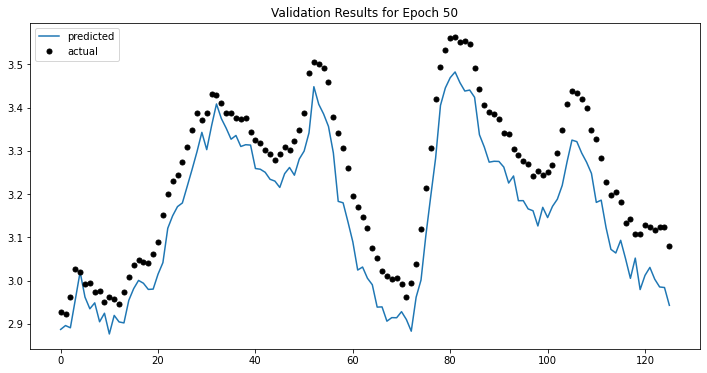

EarlyStopping counter: 9 out of 50
Iter:  51 train:  0.06660333748053648 val:  0.06630919639783642 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  52 train:  0.09322904606321669 val:  0.04577823332685773 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  53 train:  0.07451400888335397 val:  0.05444118452415087 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  54 train:  0.06395255379658578 val:  0.036424639209521735 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  55 train:  0.06343078942211425 val:  0.04115969873824762 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  56 train:  0.061153421685805426 val:  0.02758053778786043 LR:  0.01
Validation loss decreased (0.002718 --> 0.002031).  Saving model ...
Iter:  57 train:  0.09641742370832215 val:  0.020956174824929473 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  58 train:  0.06645498945928847 val:  0.06667446454748038 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  59 train:  0.0655237984984105 val:  0.030549

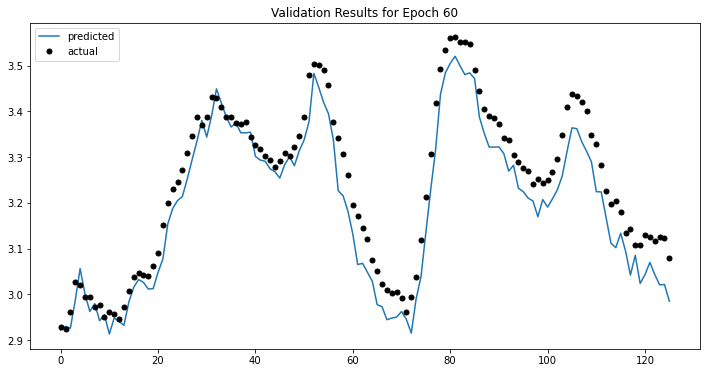

EarlyStopping counter: 4 out of 50
Iter:  61 train:  0.06610210281368444 val:  0.09072234625884491 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  62 train:  0.08393054179563937 val:  0.05084684059506066 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  63 train:  0.06300039619630309 val:  0.04216171314888901 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  64 train:  0.07641326701450359 val:  0.03907004735339867 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  65 train:  0.06083187254076794 val:  0.07848692215201966 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  66 train:  0.06352541388488588 val:  0.045069195167800793 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  67 train:  0.06945508118628327 val:  0.04696822243446019 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  68 train:  0.07025779211243717 val:  0.0476281616904107 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  69 train:  0.07548758133013288 val:  0.046648544541022866 LR:  0.01
EarlyStopping c

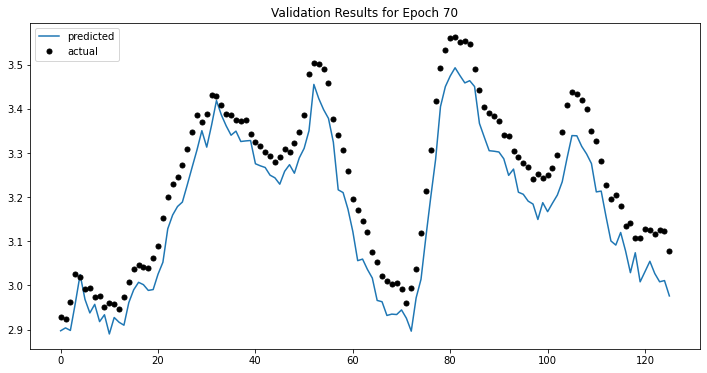

EarlyStopping counter: 14 out of 50
Iter:  71 train:  0.07089934583339841 val:  0.05114687001649094 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  72 train:  0.0649051485344805 val:  0.026653369263051868 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  73 train:  0.060665490672975254 val:  0.04030859055051762 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  74 train:  0.05400523445548992 val:  0.04139579525947606 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  75 train:  0.0531028775024059 val:  0.041602309762037104 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  76 train:  0.05619997489847977 val:  0.05183521106260053 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  77 train:  0.05398967242202865 val:  0.04690447469434465 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  78 train:  0.053392787399414006 val:  0.044263231303762994 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  79 train:  0.05494578416417285 val:  0.05003869394789629 LR:  0.001


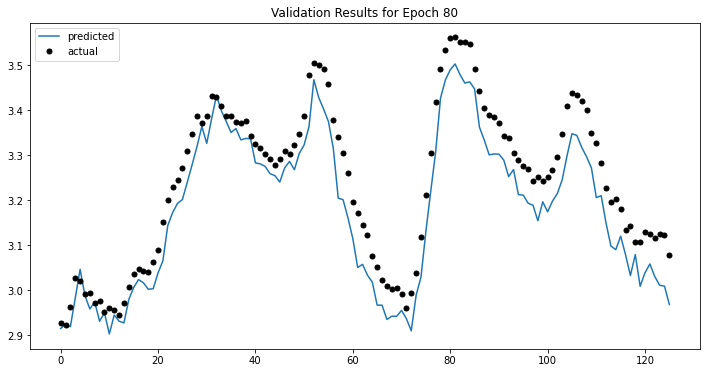

EarlyStopping counter: 24 out of 50
Iter:  81 train:  0.053981370640948066 val:  0.0438001357174188 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  82 train:  0.05270513388551283 val:  0.04797506044977626 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  83 train:  0.053393231873590095 val:  0.05134516915081896 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  84 train:  0.05477754474437568 val:  0.05211034756299711 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  85 train:  0.053224223156267715 val:  0.05135527422305227 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  86 train:  0.053159720576582734 val:  0.04551546756356793 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  87 train:  0.053036039995414654 val:  0.04043439540759783 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  88 train:  0.05444943742363136 val:  0.03596562362856856 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  89 train:  0.05506972221125848 val:  0.036052121836132316 LR:  0.

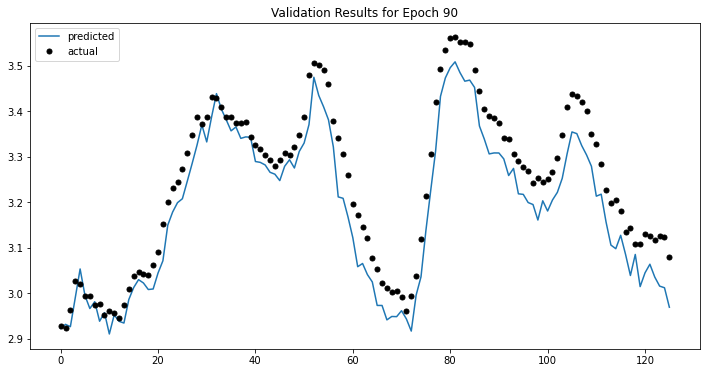

EarlyStopping counter: 34 out of 50
Iter:  91 train:  0.05181140138294146 val:  0.04765250601837963 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  92 train:  0.051738359652746924 val:  0.04336725544743905 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  93 train:  0.051580708479936385 val:  0.04589642981810104 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  94 train:  0.05162894120039923 val:  0.04595211021152404 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  95 train:  0.05170472367411973 val:  0.04458637609047227 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  96 train:  0.05161865215751744 val:  0.04460409333092734 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  97 train:  0.05157827152701201 val:  0.04726171518098617 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  98 train:  0.05169863172930935 val:  0.045752748255639686 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  99 train:  0.051624258624712115 val:  0.04624683357722783 

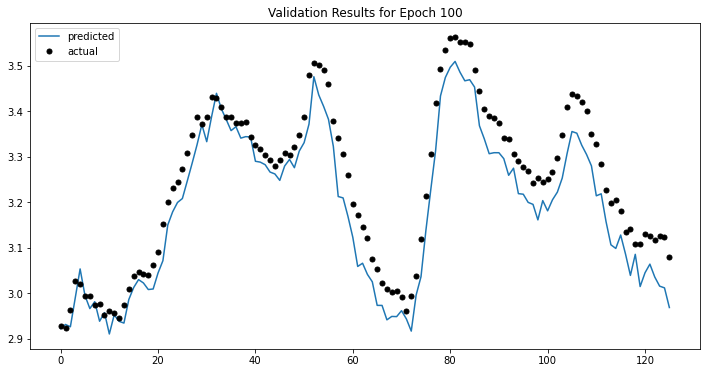

EarlyStopping counter: 44 out of 50
Iter:  101 train:  0.05164377947169256 val:  0.04391051277040609 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  102 train:  0.051687662540418906 val:  0.04317418511640469 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  103 train:  0.05175220285486178 val:  0.046139108361547075 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  104 train:  0.0516364937123988 val:  0.046510044578052516 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  105 train:  0.05156637289456239 val:  0.04532490029668919 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  106 train:  0.051409601404544036 val:  0.04523111038474038 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [52]:
nn_train(model=darnn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=darnn_opt, 
         scheduler=darnn_scheduler,
         target_scaler=target_scaler,
         device=device,
         plot=True)

### Evaluation

In [53]:
darnn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

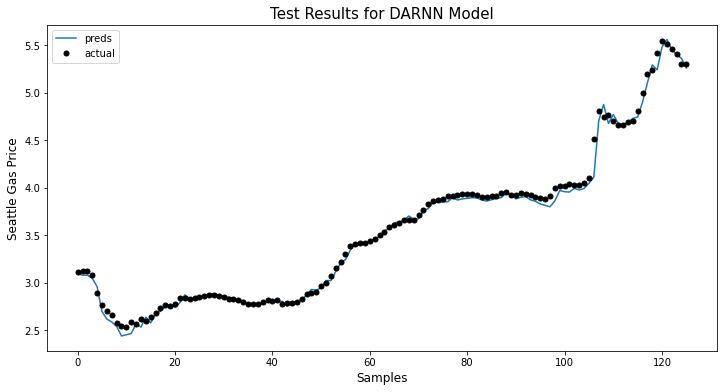

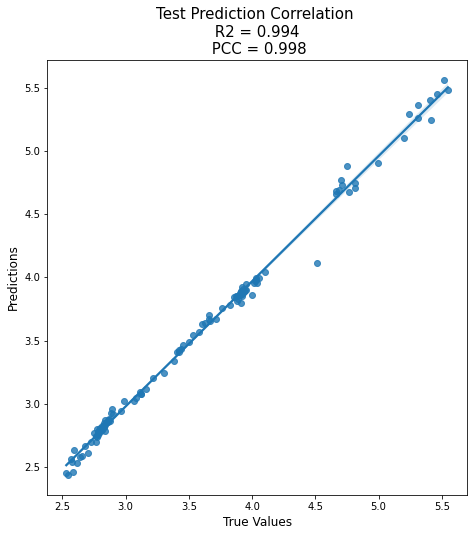

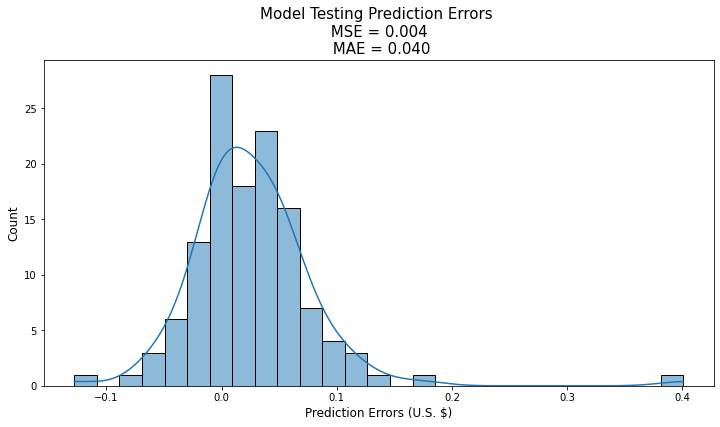

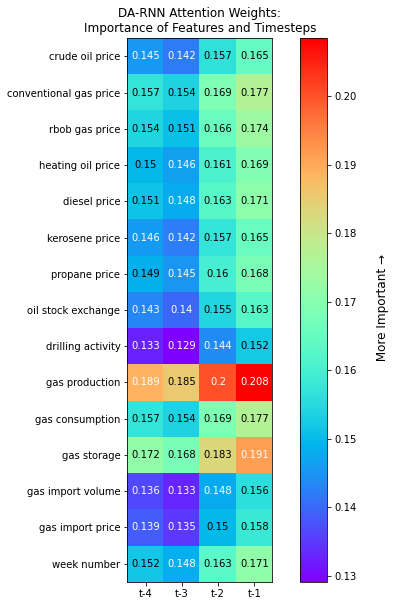

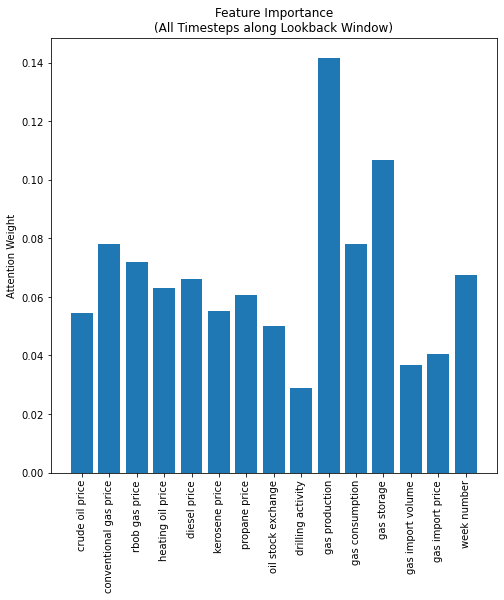

In [65]:
darnn_mse, darnn_mae, darnn_r2, darnn_pcc, darnn_preds, darnn_true, darnn_alphas, darnn_betas = nn_eval(model=darnn, 
                                                                             model_name='darnn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler, 
                                                                             device=device, 
                                                                             cols=feature_names
                                                                             )

### Forecasting

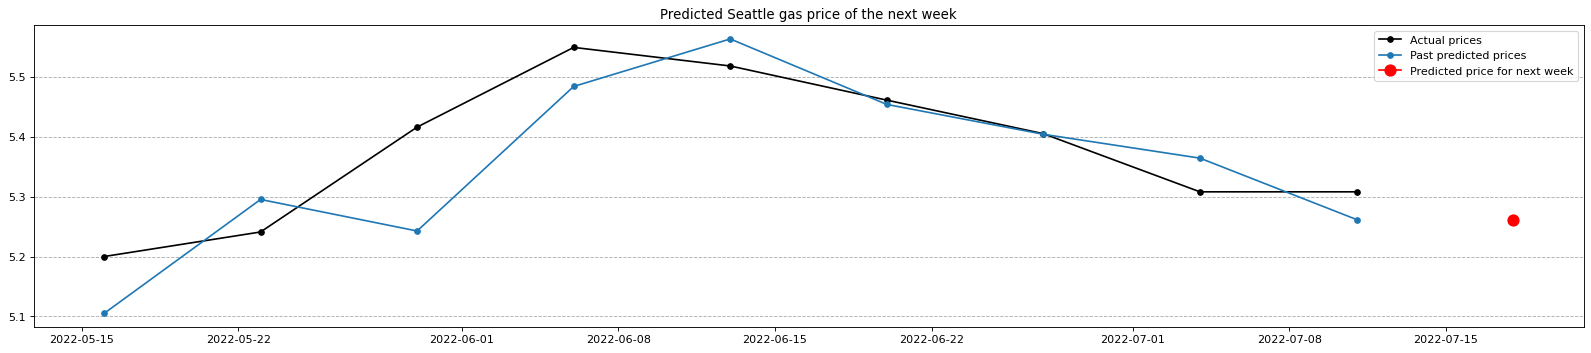

DARNN Predicted Seattle Gas Price of the next week: $5.26


In [55]:
nn_forecast(model = darnn,
            model_name = 'darnn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = darnn_true, 
            preds = darnn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler,
            device=device,
            dates=data_date, 
            plot_range=10
           )

## 5e. Hierarchical Attention-Based Recurrent Highway Network (HARHN)

### Training

In [56]:
harhn = HARHN(n_conv_layers=3, 
              T=timesteps, 
              in_feats=n_timeseries, 
              target_feats=1, 
              n_units_enc=harhn_n_enc_units, 
              n_units_dec=harhn_n_dec_units, 
              device=device
             ).to(device)
model_name = 'harhn'
harhn_opt = optim.AdamW(harhn.parameters(), lr=0.01)
harhn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=harhn_opt, patience=15)

Validation loss decreased (inf --> 0.002708).  Saving model ...
Iter:  0 train:  0.4223430565289494 val:  0.024198405679370788 LR:  0.01
mse:  0.0011454619 mae:  0.02783849


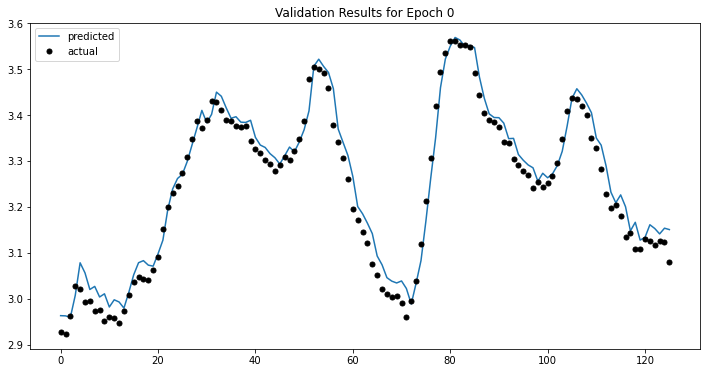

Validation loss decreased (0.002708 --> 0.001414).  Saving model ...
Iter:  1 train:  0.08821672923754977 val:  0.017487041089610692 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  2 train:  0.07042748267355109 val:  0.01826787211383733 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  3 train:  0.07169544846684336 val:  0.028956112597139958 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  4 train:  0.08371781452759432 val:  0.019766933170704545 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  5 train:  0.07771055033582834 val:  0.020906496972416165 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  6 train:  0.10685462260519656 val:  0.09223930637398561 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  7 train:  0.10245002603936867 val:  0.029036812146858198 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  8 train:  0.07845180059707269 val:  0.02590193746726419 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  9 train:  0.07409815901654464 val:  0.02869463636414343

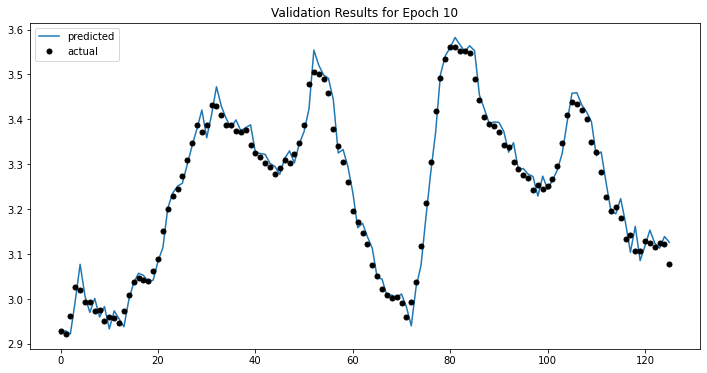

EarlyStopping counter: 10 out of 50
Iter:  11 train:  0.10234722342017832 val:  0.01973132368498796 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  12 train:  0.08343442774067882 val:  0.023865925649047836 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  13 train:  0.0743663179139895 val:  0.034751377401242144 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  14 train:  0.09539241555890456 val:  0.019482946511548138 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  15 train:  0.09062480352179679 val:  0.042795427831040345 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  16 train:  0.10459912175814987 val:  0.021153027904761867 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  17 train:  0.08891621989503252 val:  0.019112656679055234 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  18 train:  0.06507456115131346 val:  0.018326367919168234 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  19 train:  0.06222106701346101 val:  0.01867816844460403 LR:  0.001
V

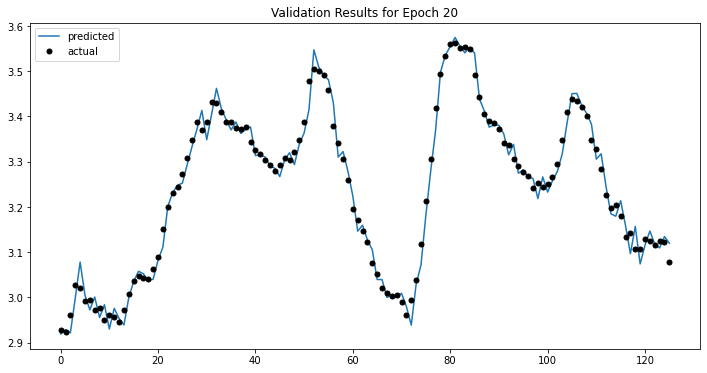

EarlyStopping counter: 1 out of 50
Iter:  21 train:  0.062227407110984886 val:  0.0177185098494802 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  22 train:  0.061920645817143204 val:  0.01769043476882736 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  23 train:  0.06214005846931508 val:  0.01748528915976202 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  24 train:  0.06387530405552538 val:  0.023378630498033855 LR:  0.001
EarlyStopping counter: 5 out of 50
Iter:  25 train:  0.06316626195582185 val:  0.017203901250844752 LR:  0.001
EarlyStopping counter: 6 out of 50
Iter:  26 train:  0.062167054329587745 val:  0.01851364628155139 LR:  0.001
EarlyStopping counter: 7 out of 50
Iter:  27 train:  0.06248436021841293 val:  0.0186150159224191 LR:  0.001
EarlyStopping counter: 8 out of 50
Iter:  28 train:  0.06515863016148885 val:  0.0259170935278065 LR:  0.001
EarlyStopping counter: 9 out of 50
Iter:  29 train:  0.06616327865478895 val:  0.017878895443854032 LR:  0.001
EarlySt

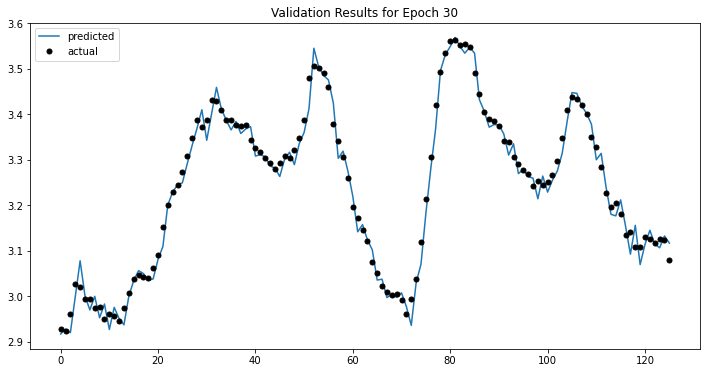

EarlyStopping counter: 11 out of 50
Iter:  31 train:  0.06248588292203896 val:  0.021625246207016204 LR:  0.001
EarlyStopping counter: 12 out of 50
Iter:  32 train:  0.06379773910928245 val:  0.021843853958434547 LR:  0.001
EarlyStopping counter: 13 out of 50
Iter:  33 train:  0.06290134277777963 val:  0.017336687111277192 LR:  0.001
EarlyStopping counter: 14 out of 50
Iter:  34 train:  0.0654087899907894 val:  0.01733598719771285 LR:  0.001
EarlyStopping counter: 15 out of 50
Iter:  35 train:  0.06296074006215219 val:  0.021622174794531518 LR:  0.001
EarlyStopping counter: 16 out of 50
Iter:  36 train:  0.06455781002502634 val:  0.01882432939898013 LR:  0.0001
EarlyStopping counter: 17 out of 50
Iter:  37 train:  0.06152438325939532 val:  0.017439682983565245 LR:  0.0001
EarlyStopping counter: 18 out of 50
Iter:  38 train:  0.06094809714441765 val:  0.017469795410519896 LR:  0.0001
EarlyStopping counter: 19 out of 50
Iter:  39 train:  0.06116155311760114 val:  0.01755622882832307 LR: 

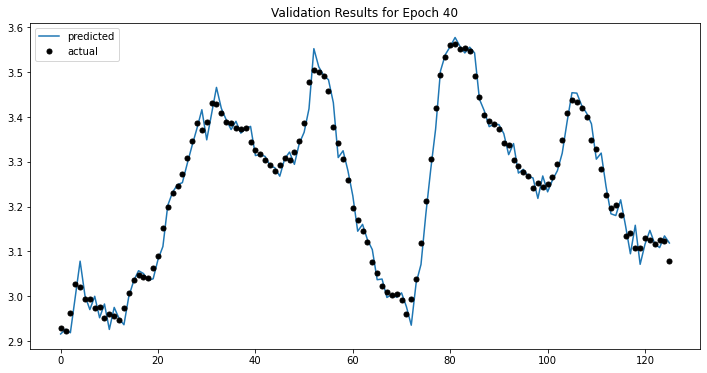

EarlyStopping counter: 21 out of 50
Iter:  41 train:  0.060935659792656846 val:  0.017659978292676067 LR:  0.0001
EarlyStopping counter: 22 out of 50
Iter:  42 train:  0.0613673989139485 val:  0.01784411112007191 LR:  0.0001
EarlyStopping counter: 23 out of 50
Iter:  43 train:  0.060939298289847864 val:  0.017460624529779707 LR:  0.0001
EarlyStopping counter: 24 out of 50
Iter:  44 train:  0.06090808406533342 val:  0.017854902816183568 LR:  0.0001
EarlyStopping counter: 25 out of 50
Iter:  45 train:  0.06131472319422258 val:  0.017721381045034377 LR:  0.0001
EarlyStopping counter: 26 out of 50
Iter:  46 train:  0.06101190441150038 val:  0.017512648978965123 LR:  0.0001
EarlyStopping counter: 27 out of 50
Iter:  47 train:  0.06109731220372483 val:  0.017538493374904648 LR:  0.0001
EarlyStopping counter: 28 out of 50
Iter:  48 train:  0.06108310043624219 val:  0.017584580783000698 LR:  0.0001
EarlyStopping counter: 29 out of 50
Iter:  49 train:  0.06093950620773763 val:  0.01789545140458

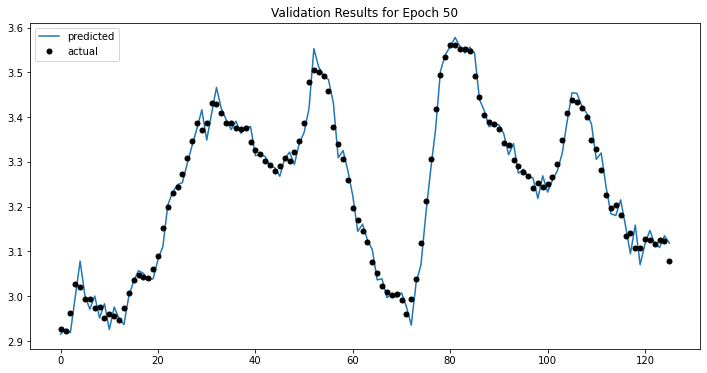

EarlyStopping counter: 31 out of 50
Iter:  51 train:  0.060882267915371595 val:  0.017966723433733282 LR:  0.0001
EarlyStopping counter: 32 out of 50
Iter:  52 train:  0.061053800950571835 val:  0.018062344731784582 LR:  1e-05
EarlyStopping counter: 33 out of 50
Iter:  53 train:  0.06108229041820663 val:  0.017659996353971592 LR:  1e-05
EarlyStopping counter: 34 out of 50
Iter:  54 train:  0.06086863866995897 val:  0.017562089428525638 LR:  1e-05
EarlyStopping counter: 35 out of 50
Iter:  55 train:  0.06081642915625531 val:  0.017541252043232345 LR:  1e-05
EarlyStopping counter: 36 out of 50
Iter:  56 train:  0.06077537787199098 val:  0.017548640049316395 LR:  1e-05
EarlyStopping counter: 37 out of 50
Iter:  57 train:  0.060773206272606135 val:  0.01754019815035887 LR:  1e-05
EarlyStopping counter: 38 out of 50
Iter:  58 train:  0.06079965698235985 val:  0.017529034854918253 LR:  1e-05
EarlyStopping counter: 39 out of 50
Iter:  59 train:  0.0608142592248578 val:  0.01754976985441016 LR

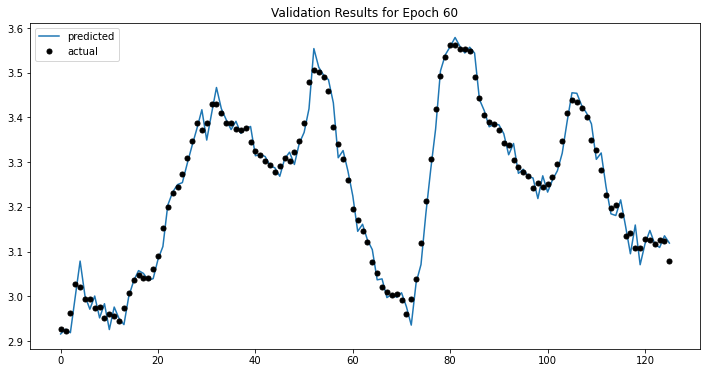

EarlyStopping counter: 41 out of 50
Iter:  61 train:  0.060785248212237894 val:  0.01752994253357604 LR:  1e-05
EarlyStopping counter: 42 out of 50
Iter:  62 train:  0.060782475250967694 val:  0.017543934371544195 LR:  1e-05
EarlyStopping counter: 43 out of 50
Iter:  63 train:  0.06078765131131569 val:  0.017528998686800086 LR:  1e-05
EarlyStopping counter: 44 out of 50
Iter:  64 train:  0.06077795344202472 val:  0.01753286827476093 LR:  1e-05
EarlyStopping counter: 45 out of 50
Iter:  65 train:  0.0607870003855925 val:  0.017529648153426423 LR:  1e-05
EarlyStopping counter: 46 out of 50
Iter:  66 train:  0.060800748766947695 val:  0.017522262150356144 LR:  1e-05
EarlyStopping counter: 47 out of 50
Iter:  67 train:  0.06079826802570068 val:  0.017550126734263493 LR:  1e-05
EarlyStopping counter: 48 out of 50
Iter:  68 train:  0.060787132478014747 val:  0.017541915450032194 LR:  1.0000000000000002e-06
EarlyStopping counter: 49 out of 50
Iter:  69 train:  0.06075525474147551 val:  0.0175

In [57]:
nn_train(model=harhn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=harhn_opt, 
         scheduler=harhn_scheduler,
         target_scaler=target_scaler,
         device=device,
         plot=True)

### Evaluation

In [58]:
harhn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

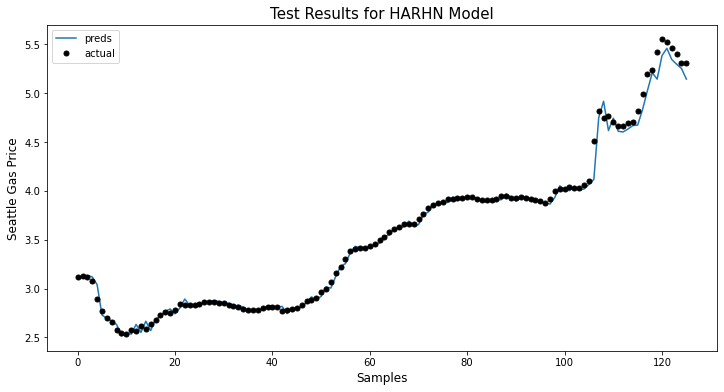

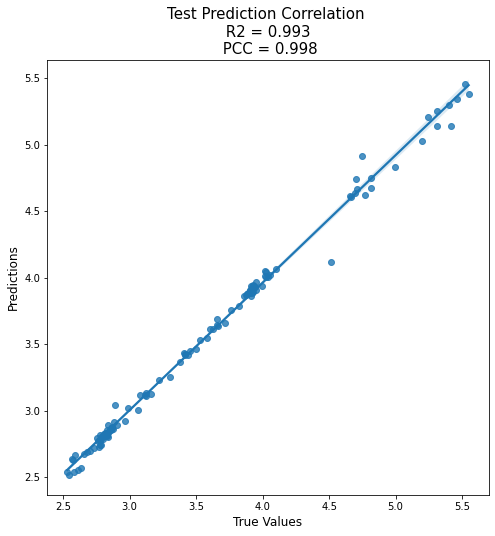

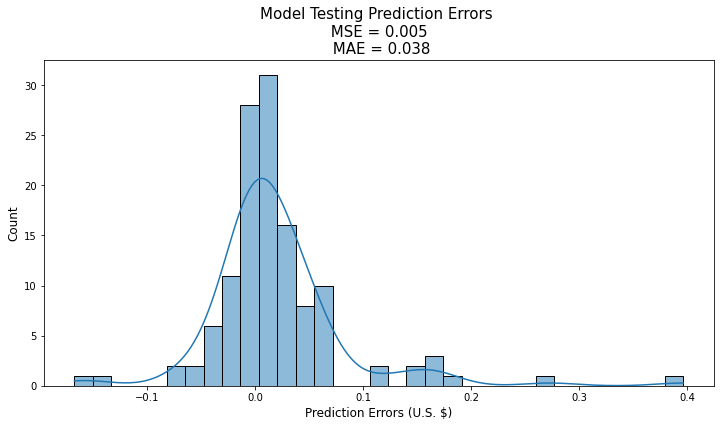

In [59]:
harhn_mse, harhn_mae, harhn_r2, harhn_pcc, harhn_preds, harhn_true, _, _ = nn_eval(model=harhn, 
                                                                             model_name='harhn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler, 
                                                                             device=device, 
                                                                             cols=feature_names
                                                                             )

### Forecast

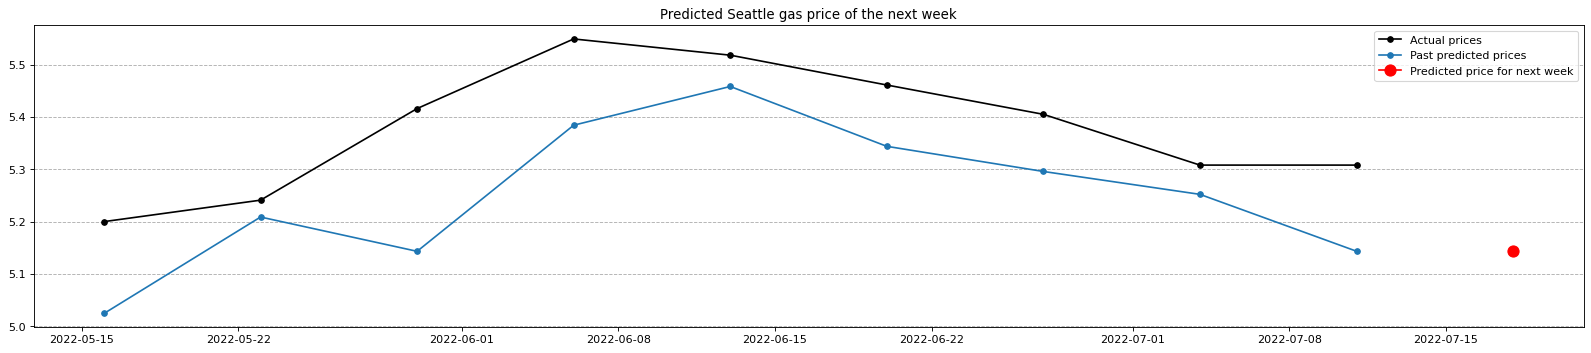

HARHN Predicted Seattle Gas Price of the next week: $5.14


In [60]:
nn_forecast(model = harhn,
            model_name = 'harhn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = harhn_true, 
            preds = harhn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            device=device,
            dates=data_date,
            plot_range=10
           )

# 6. Model Comparison

In [61]:
model_names = ['Prophet', 'Neural Prophet', 'LSTM', 'DA-RNN', 'HRHN']

df=pd.DataFrame({"Root Mean Square Err.":[prophet_mse**0.5, nprophet_mse**0.5, lstm_mse**0.5, darnn_mse**0.5, harhn_mse**0.5],
                 "Mean Absolute Err.":[prophet_mae, nprophet_mae, lstm_mae, darnn_mae, harhn_mae], 
                 "R2 Score": [prophet_r2, nprophet_r2, lstm_r2, darnn_r2, harhn_r2], 
                 "Pearson Corr. Coeff.": [prophet_pcc, nprophet_pcc, lstm_pcc, darnn_pcc, harhn_pcc]
                })
df = df.round(decimals=3)
df.index = model_names

df = df.style.highlight_max(
    subset = ['R2 Score', 'Pearson Corr. Coeff.'],
    color = 'lightgreen', axis = 0).highlight_min(
    subset = ['Root Mean Square Err.', 'Mean Absolute Err.'],
    color = 'lightgreen', axis = 0)

In [62]:
df

,Root Mean Square Err.,Mean Absolute Err.,R2 Score,Pearson Corr. Coeff.
Prophet,0.650000,0.517000,0.220000,0.518000
Neural Prophet,0.704000,0.583000,0.086000,0.720000
LSTM,0.347000,0.281000,0.814000,0.975000
DA-RNN,0.061000,0.040000,0.994000,0.998000
HRHN,0.067000,0.038000,0.993000,0.998000
